In [2]:
from bloqade import var, save, load
from bloqade.atom_arrangement import *
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
def make_hexagon (num_of_col, num_of_row, lattice_size):
    Location_list=[]
    lattice_spacing=2*lattice_size
    for i in range(num_of_col):
        for j in range(num_of_row):
            if(j>0):
                list = (0.25*lattice_spacing+3*i*lattice_spacing, (1+j*1.73)*lattice_spacing-0.433*lattice_spacing), (0*lattice_spacing+3*i*lattice_spacing, (1+j*1.73)*lattice_spacing), (0.25*lattice_spacing+3*i*lattice_spacing, (1+j*1.73)*lattice_spacing+0.433*lattice_spacing), (0.5*lattice_spacing+3*i*lattice_spacing, (1+j*1.73)*lattice_spacing+0.866*lattice_spacing), (1*lattice_spacing+3*i*lattice_spacing, (1+j*1.73)*lattice_spacing+0.866*lattice_spacing), (1.5*lattice_spacing+3*i*lattice_spacing, (1+j*1.73)*lattice_spacing+0.866*lattice_spacing), (1.75*lattice_spacing+3*i*lattice_spacing, (1+j*1.73)*lattice_spacing+0.433*lattice_spacing), (2*lattice_spacing+3*i*lattice_spacing, (1+j*1.73)*lattice_spacing), (1.75*lattice_spacing+3*i*lattice_spacing, (1+j*1.73)*lattice_spacing-0.433*lattice_spacing), (2.5*lattice_spacing+3*i*lattice_spacing, (1+j*1.73)*lattice_spacing)
                for item in list:
                    Location_list.append(item)
            else:
                list = (0*lattice_spacing+3*i*lattice_spacing,lattice_spacing), (0.25*lattice_spacing+3*i*lattice_spacing, lattice_spacing+0.433*lattice_spacing), (0.5*lattice_spacing+3*i*lattice_spacing, lattice_spacing+0.866*lattice_spacing), (lattice_spacing+3*i*lattice_spacing, lattice_spacing+0.866*lattice_spacing), (1.5*lattice_spacing+3*i*lattice_spacing, lattice_spacing+0.866*lattice_spacing), (1.75*lattice_spacing+3*i*lattice_spacing, lattice_spacing+0.433*lattice_spacing), (2*lattice_spacing+3*i*lattice_spacing, lattice_spacing), (1.75*lattice_spacing+3*i*lattice_spacing, lattice_spacing-0.433*lattice_spacing), (1.5*lattice_spacing+3*i*lattice_spacing, lattice_spacing-0.866*lattice_spacing), (1*lattice_spacing+3*i*lattice_spacing, lattice_spacing-0.866*lattice_spacing), (0.5*lattice_spacing+3*i*lattice_spacing, lattice_spacing-0.866*lattice_spacing), (0.25*lattice_spacing+3*i*lattice_spacing, lattice_spacing-0.433*lattice_spacing), (2.5*lattice_spacing+3*i*lattice_spacing, lattice_spacing)
                for item in list:
                    Location_list.append(item)
    return Location_list

In [6]:
ListOfLocations(make_hexagon(3, 3, 6.5)).show()

In [23]:
if not os.path.isdir("data"):
    os.mkdir("data")

run_time = var("run_time")

quantum_scar_program = (
    ListOfLocations(make_hexagon(1, 1, 6.5))
    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(
        [0.3, 1.6, 0.3], [-18.8, -18.8, 19, 19]
    )
    .piecewise_linear([0.2, 1.6], [19, 0.0, 0.0])
    # slice the detuning waveform
    .slice(start=0, stop=run_time)
    # define rabi waveform
    .amplitude.uniform.piecewise_linear([0.3, 1.6, 0.3], [0.0, 15.7, 15.7, 0.0])
    .piecewise_linear([0.2, 1.4, 0.2], [0, 15.7, 15.7, 0])
    # slice waveform, add padding for the linear segment
    .slice(start=0, stop=run_time - 0.065)
    # record the value of the waveform at the end of the slice to "rabi_value"
    .record("rabi_value")
    # append segment to waveform that fixes the value of the waveform to 0
    # at the end of the waveform
    .linear("rabi_value", 0, 0.065)
)

# get run times via the following:
prep_times = np.arange(0.2, 2.2, 0.2)
scar_times = np.arange(2.2, 4.01, 0.01)
run_times = np.unique(np.hstack((prep_times, scar_times)))

batch = quantum_scar_program.batch_assign(run_time=run_times)

In [24]:
emu_filename = os.path.join(
    os.path.abspath(""), "data", "quantum-scar-dynamics-emulation-hex.json"
)

emu_batch = batch.bloqade.python().run(shots=100, interaction_picture = True)
save(emu_batch, emu_filename)

In [18]:
def get_z2_probabilities(report):
    z2_probabilities = []

    for count in report.counts():
        z2_probability = count.get("101010101", 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zrz11\AppData\Local\Temp\ipykernel_9024\3347426901.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time ($\mu s$)")


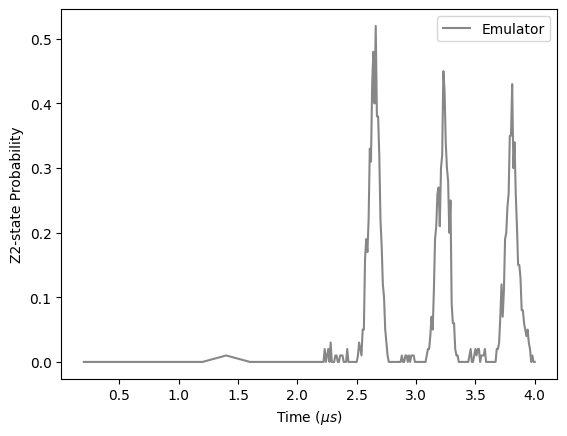

In [19]:
emu_report = emu_batch.report()
#hardware_report = hardware_batch.report()

emu_run_times = emu_report.list_param("run_time")
emu_z2_prob = get_z2_probabilities(emu_report)

#hw_run_times = hardware_report.list_param("run_time")
#hw_z2_prob = get_z2_probabilities(hardware_report)

plt.plot(emu_run_times, emu_z2_prob, label="Emulator", color="#878787")
#plt.plot(hw_run_times, hw_z2_prob, label="QPU", color="#6437FF")

plt.legend()
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Z2-state Probability")
plt.show()